# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Análisis y visualización de datos (TP1 - Parte 2: adsada)

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---

## Librerías

In [29]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

## Dataset

In [30]:
url = 'https://www.dropbox.com/scl/fi/684jriu2g52lqyv45z53s/ven_cln_map.csv?dl=1&rlkey=hr7lcqja46a9fj5bdx7ofdgah'
ventas = pd.read_csv(url, index_col=0)

In [31]:
# Discrimanción por tipo de variables
temp_cols = ['Año', 'Mes']
ven_temp = ventas[temp_cols]

cat_cols = ['ID', 'DGR', 'Categoria', 'Trat_Fisc_Agg', 'Trat_Fisc', 'Trat_Dif',
'CM', 'Deposito', 'Modelo']
ven_cat = ventas[cat_cols]

num_cols = ['Ventas', 'Alicuota', 'Comision']
ven_num = ventas[num_cols]

---
# Análisis de variables numéricas

### Estadística descriptiva (sin considerar series temporales)

In [32]:
ven_num.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,431506.0,7.544169e+06,4.837341e+07,-2.399305e+08,0.00,90996.38,3.226319e+06,4.876872e+09
Alicuota,431506.0,3.227742e+00,2.681121e+00,0.000000e+00,0.05,4.00,4.750000e+00,1.800000e+01
Comision,431506.0,2.938406e+05,1.860464e+06,-4.904327e+06,0.00,3503.35,1.268750e+05,2.438436e+08


In [33]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num[col].min() - ven_num[col].mean()) / ven_num[col].std()
    zScore_max = (ven_num[col].max() - ven_num[col].mean()) / ven_num[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Ventas:
		 Mínimo: -5 	 Máximo: 101
	Alicuota:
		 Mínimo: -1 	 Máximo: 6
	Comision:
		 Mínimo: -3 	 Máximo: 131


In [34]:
print('Proporción de valores negativos, nulos y positivos en las variables numéricas:') 
for col in num_cols:
    print(f'\t{col}')
    ans = len(ven_num[col])
    neg = len(ven_num[ven_num[col] < 0])
    nul = len(ven_num[ven_num[col] == 0])

    cant = [neg, nul, neg+nul, ans-neg-nul, ans]
    prop = [f'{100*neg/ans:.2f}%', f'{100*nul/ans:.2f}%', f'{100*(nul+neg)/ans:.2f}%', f'{100*(ans-nul-neg)/ans:.2f}%', '100.00%']
    desc = pd.DataFrame([cant, prop], columns=['Negativos', 'Nulos', 'No positivos', 'Positivos', 'Total'], index=['Cantidad', 'Proporcion'])
    display(desc)


Proporción de valores negativos, nulos y positivos en las variables numéricas:
	Ventas


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,1390,181058,182448,249058,431506
Proporcion,0.32%,41.96%,42.28%,57.72%,100.00%


	Alicuota


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,0,2757,2757,428749,431506
Proporcion,0.00%,0.64%,0.64%,99.36%,100.00%


	Comision


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,1363,183486,184849,246657,431506
Proporcion,0.32%,42.52%,42.84%,57.16%,100.00%


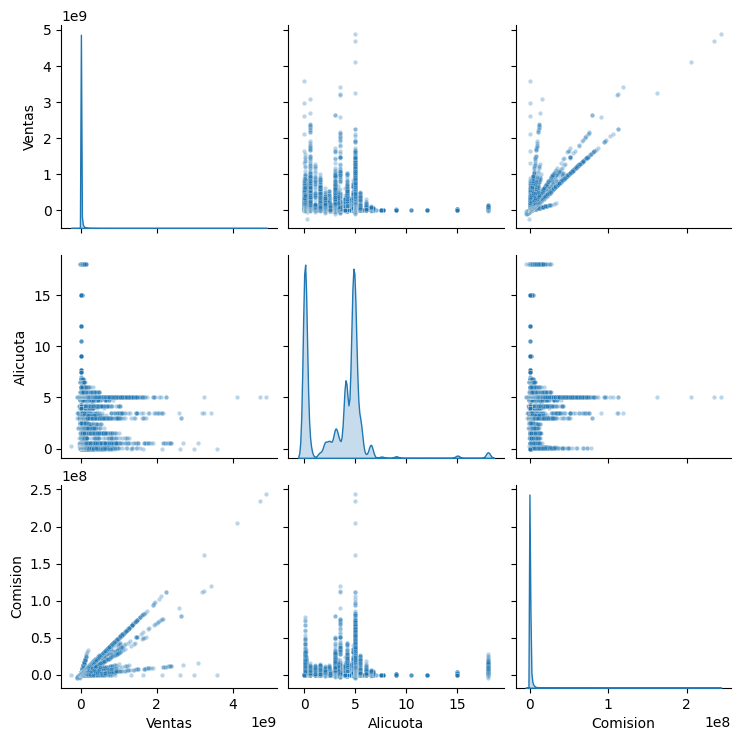

In [35]:
# Full pairplot, sin discriminar entre negativos, nulos y positivos
sns.pairplot(data=ven_num, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

### Discriminando por ventas nulas

In [39]:
ven_num_null = ven_num[ven_num['Ventas'] == 0].copy()
ven_num_not = ven_num[ven_num['Ventas'] != 0].copy()

#### DataFrame con todas las ventas nulas

In [40]:
ven_num_null.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,181058.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
Alicuota,181058.0,3.494798,2.581325,0.0,0.5,4.6,4.75,18.0
Comision,181058.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0


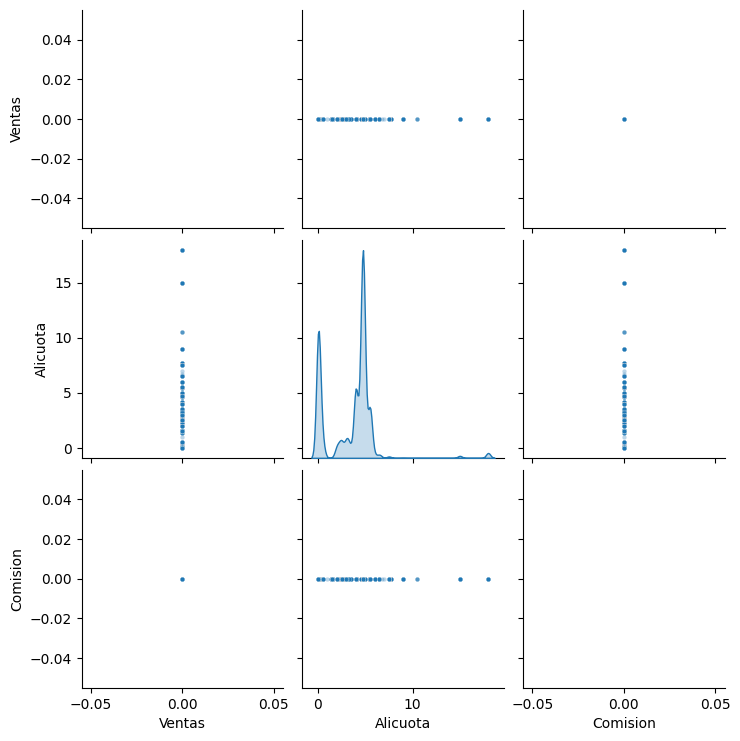

In [51]:
# Full pairplot, sin discriminar entre negativos, nulos y positivos
sns.pairplot(data=ven_num_null, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

#### DataFrame con todas las ventas no nulas

In [43]:
ven_num_not.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,250448.0,1.299812e+07,6.293460e+07,-2.399305e+08,355230.0875,2187051.770,8598866.900,4.876872e+09
Alicuota,250448.0,3.034677e+00,2.734824e+00,0.000000e+00,0.0500,4.000,5.000,1.800000e+01
Comision,250448.0,5.062686e+05,2.419940e+06,-4.904327e+06,13538.9750,85007.375,343067.555,2.438436e+08


In [44]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num_not[col].min() - ven_num_not[col].mean()) / ven_num_not[col].std()
    zScore_max = (ven_num_not[col].max() - ven_num_not[col].mean()) / ven_num_not[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Ventas:
		 Mínimo: -4 	 Máximo: 77
	Alicuota:
		 Mínimo: -1 	 Máximo: 5
	Comision:
		 Mínimo: -2 	 Máximo: 101


In [47]:
print('Proporción de valores negativos, nulos y positivos en las variables numéricas:') 
for col in num_cols:
    print(f'\t{col}')
    ans = len(ven_num_not[col])
    neg = len(ven_num_not[ven_num_not[col] < 0])
    nul = len(ven_num_not[ven_num_not[col] == 0])

    cant = [neg, nul, neg+nul, ans-neg-nul, ans]
    prop = [f'{100*neg/ans:.2f}%', f'{100*nul/ans:.2f}%', f'{100*(nul+neg)/ans:.2f}%', f'{100*(ans-nul-neg)/ans:.2f}%', '100.00%']
    desc = pd.DataFrame([cant, prop], columns=['Negativos', 'Nulos', 'No positivos', 'Positivos', 'Total'], index=['Cantidad', 'Proporcion'])
    display(desc)


Proporción de valores negativos, nulos y positivos en las variables numéricas:
	Ventas


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,1390,0,1390,249058,250448
Proporcion,0.56%,0.00%,0.56%,99.44%,100.00%


	Alicuota


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,0,1681,1681,248767,250448
Proporcion,0.00%,0.67%,0.67%,99.33%,100.00%


	Comision


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,1363,2428,3791,246657,250448
Proporcion,0.54%,0.97%,1.51%,98.49%,100.00%


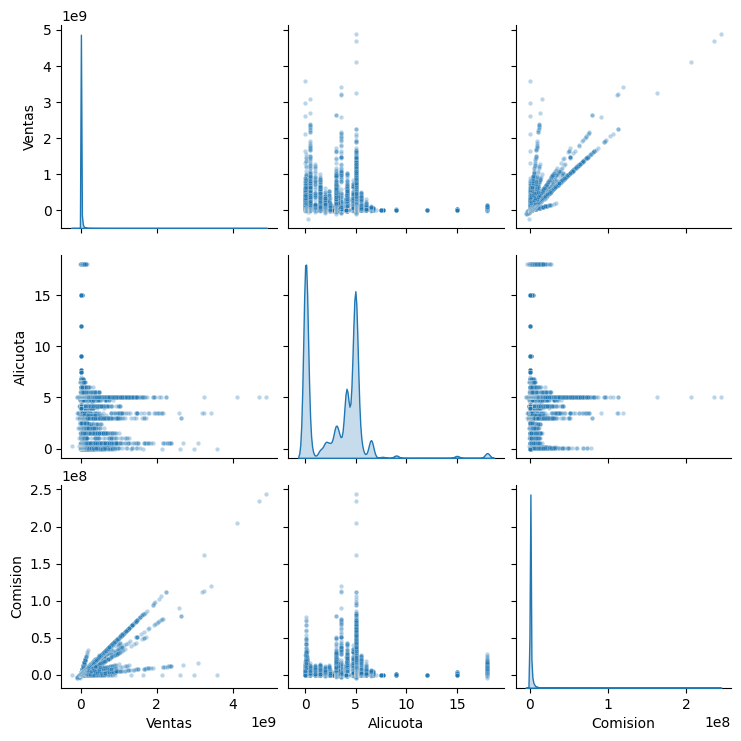

In [48]:
# Full pairplot, sin discriminar entre negativos, nulos y positivos
sns.pairplot(data=ven_num_not, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

### Más medidas de dispersión: asimetría y Kurtosis

In [66]:
asim = skew(ven_num_not)
asimtest = skewtest(ven_num_not).pvalue
kurt = kurtosis(ven_num_not)
kurttest = kurtosistest(ven_num_not).pvalue

desc = pd.DataFrame({'Asimetría': asim, 'p-val Asim.': asimtest,
                     'Kurtosis (Fisher)': kurt, 'p-val Kurt.': kurttest},
                     index=['Ventas', 'Alicuota', 'Comision'])
desc

,Asimetría,p-val Asim.,Kurtosis (Fisher),p-val Kurt.
Ventas,22.975940,0.0,893.087110,0.0
Alicuota,1.402282,0.0,6.290852,0.0
Comision,27.418292,0.0,1485.255741,0.0


---
# Análisis de variables categóricas

#### Relación entre `TRATAMIENTO_FISCAL` y `DESC_TRATAMIENTO_FISCAL`

Queremos chequear para qué valores de `TRATAMIENTO_FISCAL` aparecen valores de `DESC_TRATAMIENTO_FISCAL`. Al analizar la tabla de contingencia, vemos que los valores de `DESC_TRATAMIENTO_FISCAL` sólo aparecen cuando `TRATAMIENTO_FISCAL` asume valores 0, 1, 2 ó 3. A su vez, hay correspondencia entre 0 y Normal, 1 y Exento/Desgravado, 2 y Minorista, 3 y Otro Tratamiento Fiscal. ¿Se puede unificar todo como `TRATAMIENTO_FISCAL`, eliminando entonces `DESC_TRATAMIENTO_FISCAL`? ¿Tiene sentido que falte la descripción asociada al tratamiento?

In [ ]:
# Este paso lo agrego porque sino el crosstab siguiente no me muestra los NaN
prueba3 = ventas_clean.copy()
prueba3['TRATAMIENTO_FISCAL'] = prueba3['TRATAMIENTO_FISCAL'].fillna('Waring: Relleno')
prueba3['DESC_TRATAMIENTO_FISCAL'] = prueba3['DESC_TRATAMIENTO_FISCAL'].fillna('Waring: Relleno')

In [ ]:
pd.crosstab(prueba3['TRATAMIENTO_FISCAL'], prueba3['DESC_TRATAMIENTO_FISCAL'], dropna=False)

#### Relación entre `TRATAMIENTO_FISCAL` y `TRATAMIENTO_DIFERENCIAL`

Ahora veamos para qué valores de `TRATAMIENTO_FISCAL` aparecen valores de `TRATAMIENTO_DIFERNCIAL`. Al analizar la tabla de contingencia vemos que no hay un patrón claro. ¿Podríamos tomar a un dato faltante como "sin tratamiento" o algo por el estilo?

In [ ]:
# Este paso lo agrego porque sino el crosstab siguiente no me muestra los NaN
prueba3['TRATAMIENTO_DIFERNCIAL'] = prueba3['TRATAMIENTO_DIFERNCIAL'].fillna('Waring: Relleno')

In [ ]:
pd.crosstab(prueba3['TRATAMIENTO_FISCAL'], prueba3['TRATAMIENTO_DIFERNCIAL'], dropna=False)

---
# Paso 1: Carga y exploración inicial de datos

### Construcción de una nueva variable: Fecha

Consideramos que para el análisis temporal habrá momentos en que necesitamos tener año y mes por separado, pero en otras ocasiones necesitamos toda la información al mismo tiempo. Por lo tanto, creamos la variable fecha:
    $$FECHA = AÑO + MES$$

In [ ]:
ventas_clean['FECHA'] = pd.to_datetime(ventas_clean['MES'].astype(str) + '-' + ventas_clean['AÑO'].astype(str), format='%m-%Y')
display(ventas_clean[:3])

In [ ]:
ventas_clean['FECHA'].dtypes

### Algunas pruebas con variables numéricas

#### Relación numérica entre `TOTAL_VENTAS`, `PORCENTAJE_COMISION_EMPRESA` y `COMISION_EMPRESA`

Queremos estudiar un poco más la relación lineal antes vista entre estas 3 variables. Proponemos que la función es
    $$\text{COMISION\_EMPRESA} = \text{PORCENTAJE\_COMISION\_EMPRESA} \times \text{TOTAL\_VENTAS}$$

Vemos que la fórmula es exacta sólo para 190.999 registros. Si probamos con algún margen de error, la fórmula verifica con precisión menor a 1 entero para 261.272 registros (menos del 61% de los registros totales).

In [ ]:
# Probemos con verificar la siguiente fórmula:
ventas_clean['ComCalc'] = ventas_clean['TOTAL_VENTAS'] * ventas_clean['PORCENTAJE_COMISION_EMPRESA']

In [ ]:
for x in [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 50, 100, 1000]:
  print('Para', x, 'de diferencia, tenemos', sum(abs(ventas_clean['COMISION_EMPRESA'] - ventas_clean['ComCalc']) <= x), 'igualdades')

Tenemos que en el 44.26% de los casos la relación lineal que proponemos es exacta. Respecto a la fracción restante, en el 8.19% de los casos la subestima, mientras que en el 47.55% la sobreestima.

In [ ]:
diferencia = ventas_clean['COMISION_EMPRESA'] - ventas_clean['ComCalc']
print(f'Exactos: {100*len(diferencia[diferencia==0])/len(diferencia):.2f}')
print(f'Positivos: {100*len(diferencia[diferencia>0])/len(diferencia):.2f}')
print(f'Negativos: {100*len(diferencia[diferencia<0])/len(diferencia):.2f}')

In [ ]:
# Grafiquemos la distribución de la diferencia
plt.boxplot(diferencia.dropna())
plt.xlabel('Diferencia')
plt.ylabel('Valor')
plt.title('Diferencia entre comisión empresa real y calculada')
plt.show()

Vemos que, a pesar de las diferencias entre el valor real y el predicho, se pueden apreciar claramente 2 pendientes: una muy grande y otra bastante más pequeña. Esas dos rectas serían las que describen mejor la tendencia de los puntos y, por lo tanto, explicarían la relación entre las 3 variables de interés.

In [ ]:
com_real_sobre = ventas_clean['COMISION_EMPRESA'][diferencia<0]
com_real_exac = ventas_clean['COMISION_EMPRESA'][diferencia==0]
com_real_sub = ventas_clean['COMISION_EMPRESA'][diferencia>0]

com_calc_sobre = ventas_clean['ComCalc'][diferencia<0]
com_calc_exac = ventas_clean['ComCalc'][diferencia==0]
com_calc_sub = ventas_clean['ComCalc'][diferencia>0]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(com_real_sobre, com_calc_sobre, label='Sobreestimado', s=30)
axs[0].scatter(com_real_exac, com_calc_exac, label='Exacto', s=20)
axs[0].scatter(com_real_sub, com_calc_sub, label='Subestimado', s=10)

axs[0].legend()

axs[0].set_xlabel('Comisión real')
axs[0].set_ylabel('Comisión Calculada')

axs[1].scatter(com_real_sobre, com_calc_sobre, label='Sobreestimado', s=30)
axs[1].scatter(com_real_exac, com_calc_exac, label='Exacto', s=20)
axs[1].scatter(com_real_sub, com_calc_sub, label='Subestimado', s=10)

axs[1].legend()
axs[1].set_ylim(-5E8, 1E8)
axs[1].set_xlim(-0.5E7, 3.5E7)

axs[1].set_xlabel('Comisión real')
axs[1].set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada')
plt.show()

Vemos que entonces tenemos 2 rectas que definen la relación entre las variables de interés. Por un lado, el 61% de los datos responde a la ecuación antes planteada, sumando un pequeño offset:
    $$\text{Com. Calc} = \text{Com. Real} + \$0.48 = \text{Porcent. Com.} \times \text{Ventas}$$
    $$\Rightarrow \text{Com. Real} = \text{Porcent. Com.} \times \text{Ventas} - \$0.48$$

El resto de los datos responde a una ecuación completamente distinta:
    $$\text{Com. Calc} = 100 * \text{Com. Real} + \$1365 = \text{Porcent. Com.} \times \text{Ventas}$$
    $$\Rightarrow \text{Com. Real} = \frac{\text{Porcent. Com.} \times \text{Ventas} - \$1365}{100} = 0.01 \times \text{Porcent. Com.} \times \text{Ventas} - \$13.65 $$

No olvidar que esto sale considerando absolutamente todos los valores (no se descaartó ni se truncó nada).

In [ ]:
rg_real = pd.concat([com_real_sub[com_calc_sub<0], com_real_sobre[com_calc_sobre>10*com_real_sobre]])
rg_calc = pd.concat([com_calc_sub[com_calc_sub<0], com_calc_sobre[com_calc_sobre>10*com_real_sobre]])

rp_real = pd.concat([com_real_sub[com_calc_sub>0], com_real_sobre[com_calc_sobre<10*com_real_sobre], com_real_exac])
rp_calc = pd.concat([com_calc_sub[com_calc_sub>0], com_calc_sobre[com_calc_sobre<10*com_real_sobre], com_calc_exac])

In [ ]:
print(len(rg_real))
print(len(rp_real))
print(len(rp_real+rg_real))

In [ ]:
LG = LR(rg_real, rg_calc)
LP = LR(rp_real, rp_calc)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs[0].scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs[0].plot(rg_real, rg_real*LG.slope + LG.intercept, label=f'{LG.slope:.0f}*Real + {LG.intercept:.0f}', color='red')
axs[0].plot(rp_real, rp_real*LP.slope + LP.intercept, label=f'{LP.slope:.0f}*Real + {LP.intercept:.2f}', color='tab:green')

axs[0].legend(loc='upper left')

axs[0].set_xlabel('Comisión real')
axs[0].set_ylabel('Comisión Calculada')

axs[1].scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs[1].scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs[1].plot(rg_real, rg_real*LG.slope + LG.intercept, label=f'{LG.slope:.0f}*Real + {LG.intercept:.0f}', color='red')
axs[1].plot(rp_real, rp_real*LP.slope + LP.intercept, label=f'{LP.slope:.0f}*Real + {LP.intercept:.2f}', color='tab:green')

axs[1].legend(loc='lower right')
axs[1].set_ylim(-1E8, 1E8)
axs[1].set_xlim(-0.5E7, 4E7)

axs[1].set_xlabel('Comisión real')
axs[1].set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada')
plt.show()

#### Rectas obtenida vs vendedor modelo

Ahora comparamos las dos rectas obtenidas en función de la clasificación de modelo dada por el cliente. Vemos que todos los vendedores modelo caen dentro de la recta de menor pendiente, la cual establece prácticamente una relación de proporcionalidad directa entre las ventas y la comisión de la empresa. Por su parte, los que no están clasificados como modelo caen sobre ambas rectas. ¿Puede ser este un camino para detectar la fuga?

In [ ]:
mask0 = ventas_clean['MODELO']==0
mask1 = ventas_clean['MODELO']==1

In [ ]:
com_real_Mod = ventas_clean['COMISION_EMPRESA'][mask1]
com_real_noMod = ventas_clean['COMISION_EMPRESA'][mask0]

com_calc_Mod = ventas_clean['ComCalc'][mask1]
com_calc_noMod = ventas_clean['ComCalc'][mask0]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs[0].scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs[0].plot(com_real_noMod, com_calc_noMod, label='No Modelo', color='tab:green')
axs[0].plot(com_real_Mod, com_calc_Mod, label='Modelo', color='red')

axs[0].legend(loc='upper left')

axs[0].set_xlabel('Comisión real')
axs[0].set_ylabel('Comisión Calculada')

axs[1].scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs[1].scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs[1].plot(com_real_noMod, com_calc_noMod, label='No Modelo', color='tab:green')
axs[1].plot(com_real_Mod, com_calc_Mod, label='Modelo', color='red')

axs[1].legend(loc='lower right')
axs[1].set_ylim(-1E8, 1E8)
axs[1].set_xlim(-0.5E7, 4E7)

axs[1].set_xlabel('Comisión real')
axs[1].set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada')
plt.show()

---
# Paso 2: Análisis estadístico descriptivo

Vamos a considerar que la serie temporal **principal** es la dictada por `TOTAL_VENTAS`.

### Considerando la serie temporal

#### Agrupando por meses

Se entiende más la progresión al agrupar todos los datos correspondientes a un mismo mes. Vemos que no hace otra cosa más que crecer. Se observa el efecto de la inflación y pareciera haber picos hacia fin de año.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(ventas_clean['FECHA'],ventas_clean['TOTAL_VENTAS'])

axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Ventas')
axs[0].set_title('Ventas sin agregar')

prueba6 = ventas_clean[['FECHA','TOTAL_VENTAS', 'AÑO']].copy()
prueba6_agregado = prueba6.groupby('FECHA')['TOTAL_VENTAS'].sum().reset_index()

axs[1].plot(prueba6_agregado['FECHA'], prueba6_agregado['TOTAL_VENTAS'])

axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Ventas')
axs[1].set_title('Ventas agregadas por mes')

plt.show()

Son más similares las tendencias desde el 2019 al 2021, mientras que 2022 se destaca por ser bien diferente.

In [ ]:
mes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

v19 = prueba6_agregado['TOTAL_VENTAS'][:12]
v20 = prueba6_agregado['TOTAL_VENTAS'][12:24]
v21 = prueba6_agregado['TOTAL_VENTAS'][24:36]
v22 = prueba6_agregado['TOTAL_VENTAS'][36:]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(mes, v19, label='2019', marker='o')
axs[0].plot(mes, v20, label='2020', marker='o')
axs[0].plot(mes, v21, label='2021', marker='o')
axs[0].plot(mes[:6], v22, label='2022', marker='o')

axs[0].set_xlabel('Mes')
axs[0].set_ylabel('Ventas')
axs[0].set_title('Original')
axs[0].legend()

axs[1].plot(mes, v19/np.max(v19), label='2019', marker='o')
axs[1].plot(mes, v20/np.max(v20), label='2020', marker='o')
axs[1].plot(mes, v21/np.max(v21), label='2021', marker='o')
axs[1].plot(mes[:6], v22/np.max(v22), label='2022', marker='o')

axs[1].set_xlabel('Mes')
axs[1].set_ylabel('Ventas')
axs[1].set_title('Normalizadas')
axs[1].legend()

fig.suptitle('Ventas agregadas por mes y separadas por año')

plt.show()

#### Estacionalidad un poco más definida - mensual

Se dice que una serie de tiempo es estacionaria si no aumenta o disminuye con el tiempo de forma lineal o exponencial (sin tendencias), y si no muestra ningún tipo de patrón repetitivo (sin estacionalidad). Matemáticamente, esto se describe como una media constante y una varianza constante a lo largo del tiempo. Junto con la varianza, la autocovarianza tampoco debería ser una función del tiempo.

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(data=ventas_clean, x='MES', y='TOTAL_VENTAS', ax=axs[0])

sns.boxplot(data=ventas_clean, x='MES', y='TOTAL_VENTAS', ax=axs[1])
axs[1].set_ylim(-0.6E7, 1.2E7)

fig.suptitle('Estacionalidad mensual considerando los 4 años juntos')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(24, 20))

sns.boxplot(data=ventas_clean[ventas_clean['AÑO']==2019], x='MES', y='TOTAL_VENTAS', ax=axs[0, 0])
sns.boxplot(data=ventas_clean[ventas_clean['AÑO']==2019], x='MES', y='TOTAL_VENTAS', ax=axs[1, 0])

sns.boxplot(data=ventas_clean[ventas_clean['AÑO']==2020], x='MES', y='TOTAL_VENTAS', ax=axs[0, 1])
sns.boxplot(data=ventas_clean[ventas_clean['AÑO']==2020], x='MES', y='TOTAL_VENTAS', ax=axs[1, 1])

sns.boxplot(data=ventas_clean[ventas_clean['AÑO']==2021], x='MES', y='TOTAL_VENTAS', ax=axs[0, 2])
sns.boxplot(data=ventas_clean[ventas_clean['AÑO']==2021], x='MES', y='TOTAL_VENTAS', ax=axs[1, 2])

sns.boxplot(data=ventas_clean[ventas_clean['AÑO']==2022], x='MES', y='TOTAL_VENTAS', ax=axs[0, 3])
sns.boxplot(data=ventas_clean[ventas_clean['AÑO']==2022], x='MES', y='TOTAL_VENTAS', ax=axs[1, 3])

axs[0, 0].set_title('2019')
axs[1, 0].set_ylim(-0.6E7, 1.2E7)

axs[0, 1].set_title('2020')
axs[1, 1].set_ylim(-0.6E7, 1.2E7)

axs[0, 2].set_title('2021')
axs[1, 2].set_ylim(-0.6E7, 1.2E7)

axs[0, 3].set_title('2022')
axs[1, 3].set_ylim(-0.6E7, 1.2E7)

fig.suptitle('Estacionalidad mensual por año')
plt.show()

#### Estacionalidad un poco más definida - anual

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(data=ventas_clean, x='AÑO', y='TOTAL_VENTAS', ax=axs[0])

sns.boxplot(data=ventas_clean, x='AÑO', y='TOTAL_VENTAS', ax=axs[1])
axs[1].set_ylim(-0.6E7, 1.2E7)

fig.suptitle('Estacionalidad anual considerando los 12 meses juntos')
plt.show()

#### Autocorrelación

Hay correlación estadísticamente significativa para los lags 1, 2 y 3, lo que implica que observaciones pasadas influyen en las observaciones actuales de la serie temporal de manera positiva.

In [ ]:
# Calcular la función de autocorrelación
acf = plot_acf(prueba6_agregado['TOTAL_VENTAS'], lags=12)

# Graficar la función de autocorrelación
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.show()

---
# Paso 4: Distribución de frecuencias y probabilidades

### Comparación entre las variables categóricas

#### `ID_VENDEDOR` vs `INSCRIPCION`

Vemos que la correlación es extremadamente pobre, por lo que decimos que no hay correlación.

In [ ]:
vad = pd.crosstab(ventas_clean['ID_VENDEDOR'], ventas_clean['INSCRIPCION'], normalize=True)
vad

In [ ]:
rows = []
for k in range(vad.shape[0]):
    rows.append(np.sum(vad.iloc[k, :]))
rows = np.array(rows)

cols = []
for k in range(vad.shape[1]):
    cols.append(np.sum(vad.iloc[:, k]))
cols = np.array(cols)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(rows)
axs[1].plot(cols)

plt.show()

#### `TRATAMIENTO_FISCAL` vs `DESC_TRATAMIENTO_FISCAL`

Vemos que sí existe una gran correlación entre "Norm" de `DESC_TRATAMIENTO_FISCAL` y "0" de `TRATAMIENTO_FISCAL`.

In [ ]:
vad = pd.crosstab(ventas_clean['TRATAMIENTO_FISCAL'], ventas_clean['DESC_TRATAMIENTO_FISCAL'], normalize=True)
vad

#### `TRATAMIENTO_FISCAL` vs `TRATAMIENTO_DIFERENCIAL`

No hay ninguna correlación muy intensa.

In [ ]:
vad = pd.crosstab(ventas_clean['TRATAMIENTO_FISCAL'], ventas_clean['TRATAMIENTO_DIFERNCIAL'], normalize=True)
vad

#### `DESC_TRATAMIENTO_FISCAL` vs `TRATAMIENTO_DIFERENCIAL`

Existe una correlación baja/moderada entre "Art.21" de `TRATAMIENTO_DIFERNCIAL` y "Norm" de `DESC_TRATAMIENTO_FISCAL`

In [ ]:
vad = pd.crosstab(ventas_clean['DESC_TRATAMIENTO_FISCAL'], ventas_clean['TRATAMIENTO_DIFERNCIAL'], normalize=True)
vad

### Por si queremos truncar por variables numércias

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(x=ventas_clean['TOTAL_VENTAS'], ax=axs[0, 0], notch=True, 
            flierprops={"marker": "x"}, medianprops={"color": "coral"})

sns.boxplot(x=ventas_clean['TOTAL_VENTAS'], ax=axs[0, 1], notch=True, 
            flierprops={"marker": "x"}, medianprops={"color": "coral"})

axs[0, 1].set_xlim(-0.6E7, 1E7)

sns.boxplot(x=ventas_clean['COMISION_EMPRESA'], ax=axs[1, 0], notch=True, 
            flierprops={"marker": "x"}, medianprops={"color": "coral"})

sns.boxplot(x=ventas_clean['COMISION_EMPRESA'], ax=axs[1, 1], notch=True, 
            flierprops={"marker": "x"}, medianprops={"color": "coral"})

axs[1, 1].set_xlim(-3E5, 4E5)

plt.show()

Para atacar el problema de los valores extremos podemos proponer quedarnos con cierta porción de la distribución usando percentiles. Como tiene mucha cola hacia la derecha, nos quedamos primero con la porción izquierda de la población.

In [ ]:
print(f'Teníamos {len(ventas_clean)} registros.')
dftest = ventas_clean.copy()

fig, axs = plt.subplots(1, 4, figsize=(24, 5))

sns.boxplot(x=ventas_clean['TOTAL_VENTAS'], ax=axs[0], notch=True, 
            flierprops={"marker": "x"}, medianprops={"color": "coral"})

percentile_sup = dftest['TOTAL_VENTAS'].quantile(0.995)
dfk = dftest[dftest['TOTAL_VENTAS'] < percentile_sup]
print(f'Tomando el 99.5% central quedan {len(dfk)} registros.')
sns.boxplot(x=dfk['TOTAL_VENTAS'], ax=axs[1], notch=True, 
            flierprops={"marker": "x"}, medianprops={"color": "coral"})

percentile_sup = dftest['TOTAL_VENTAS'].quantile(0.990)
dfk = dftest[dftest['TOTAL_VENTAS'] < percentile_sup]
print(f'Tomando el 99.0% central quedan {len(dfk)} registros.')
sns.boxplot(x=dfk['TOTAL_VENTAS'], ax=axs[2], notch=True, 
            flierprops={"marker": "x"}, medianprops={"color": "coral"})

percentile_sup = dftest['TOTAL_VENTAS'].quantile(0.950)
dfk = dftest[dftest['TOTAL_VENTAS'] < percentile_sup]
print(f'Tomando el 95.0% central quedan {len(dfk)} registros.')
sns.boxplot(x=dfk['TOTAL_VENTAS'], ax=axs[3], notch=True, 
            flierprops={"marker": "x"}, medianprops={"color": "coral"})

axs[0].set_title(f'100% de la distribución')
axs[1].set_title(f'99.5% izquierdo de la distribución')
axs[2].set_title(f'99.0% izquierdo de la distribución')
axs[3].set_title(f'95.0% izquierdo de la distribución')

plt.show()